<a href="https://colab.research.google.com/github/Vindhya07/ML_Covid_TimeSeries/blob/main/Covid_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [91]:
df = pd.read_csv('whac.csv')
df.head()
print(df.shape)

df2 = pd.read_csv('c19.csv')
print(df2.head())
print(df2.shape)



(2096, 4)
               X             Y  ... Aged75to84  Aged85up
0 -856335.869598  7.036492e+06  ...        NaN       NaN
1 -856335.869598  7.036492e+06  ...        NaN       NaN
2 -856335.869598  7.036492e+06  ...        0.0       0.0
3 -856335.869598  7.036492e+06  ...        0.0       0.0
4 -856335.869598  7.036492e+06  ...        0.0       0.0

[5 rows x 41 columns]
(639, 41)


In [82]:
df_Ireland = df.loc[df['Entity'] == 'Ireland'].reset_index()
# df_Ireland = df_Ireland.reset_index()
print(df_Ireland.shape)



(84, 5)


In [4]:
print(df_Ireland)

    index   Entity Code         Day  Weekly new hospital admissions
0     838  Ireland  IRL  2020-04-12                         493.830
1     839  Ireland  IRL  2020-04-19                         349.294
2     840  Ireland  IRL  2020-04-26                         306.134
3     841  Ireland  IRL  2020-05-03                         261.971
4     842  Ireland  IRL  2020-05-10                         162.603
..    ...      ...  ...         ...                             ...
79    917  Ireland  IRL  2021-10-24                         357.324
80    918  Ireland  IRL  2021-10-31                         406.506
81    919  Ireland  IRL  2021-11-07                         373.384
82    920  Ireland  IRL  2021-11-14                         509.889
83    921  Ireland  IRL  2021-11-21                         549.034

[84 rows x 5 columns]


In [112]:
# df_Ireland['Day'] = pd.to_datetime(df_Ireland['Day'])
# for index, row in df_Ireland.iterrows():
#     print(index, row['Day'], row['Entity'], row['Weekly new hospital admissions'])

# print(df_Ireland.dtypes)


df2['Date'] = pd.to_datetime(df2['Date'])
df2['HCC'] = df2['HospitalisedCovidCases'].fillna(0)

# for index, row in df2.iterrows():
#     print(index, row['Date'], row['HCC'])

prev_num = 0
df2['new_HCC'] = df2['HCC']
for index,row in df2.iterrows():
  df2.at[index, 'new_HCC'] = row['HCC'] - prev_num
  prev_num = row['HCC']
  # print(index, row['Date'], row['HCC'], row['new_HCC'])

print(df2['new_HCC'])






0       0.0
1       0.0
2       0.0
3       1.0
4       3.0
       ... 
634    26.0
635    39.0
636    41.0
637    19.0
638     8.0
Name: new_HCC, Length: 639, dtype: float64


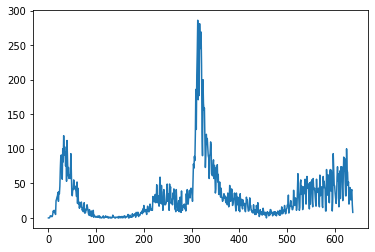

In [113]:
i_range = []
for i in range(639):
  i_range.append(i)

plt.plot(i_range, df2['new_HCC'])
plt.show()

In [115]:
print("")

In [49]:
start=pd.to_datetime('2020-12-13 00:00:00')
print("Start: ", start)
end=pd.to_datetime('2021-04-18 00:00:00')
print("End: ", end)
t_full=pd.array(pd.DatetimeIndex(df_Ireland.iloc[35:53,3]).astype(np.int64))/1000000000
print("Tfull: ", t_full)
dt = t_full[1] - t_full[0] 
print("Data sampling interval in seconds:", dt)

Start:  2020-12-13 00:00:00
End:  2021-04-18 00:00:00
Tfull:  <PandasArray>
[1607817600.0, 1608422400.0, 1609027200.0, 1609632000.0, 1610236800.0,
 1610841600.0, 1611446400.0, 1612051200.0, 1612656000.0, 1613260800.0,
 1613865600.0, 1614470400.0, 1615075200.0, 1615680000.0, 1616284800.0,
 1616889600.0, 1617494400.0, 1618099200.0]
Length: 18, dtype: float64
Data sampling interval in seconds: 604800.0


Float64Index([1607817600.0], dtype='float64')
Float64Index([1618704000.0], dtype='float64')
<PandasArray>
[1607817600.0, 1608422400.0, 1609027200.0, 1609632000.0, 1610236800.0,
 1610841600.0, 1611446400.0, 1612051200.0, 1612656000.0, 1613260800.0,
 1613865600.0, 1614470400.0, 1615075200.0, 1615680000.0, 1616284800.0,
 1616889600.0, 1617494400.0, 1618099200.0]
Length: 18, dtype: float64
7.0
<PandasArray>
[            81.301,            128.476,            185.688,
            478.774,             866.21,           1077.994,
            724.685,            553.049,            416.543,
 309.14599999999996,            316.172,            195.725,
 167.62099999999998,            155.576,            193.718,
            145.539,            118.439,             81.301]
Length: 18, dtype: float64
Y=: [1607817600 1608422400 1609027200 1609632000 1610236800 1610841600
 1611446400 1612051200 1612656000 1613260800 1613865600 1614470400
 1615075200 1615680000 1616284800 1616889600 1617494400 161809

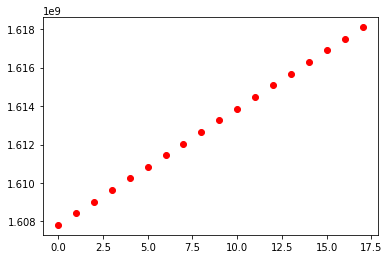

In [79]:
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
print(t_start)
print(t_end)
print(t_full)
# d = (t_full>=start) & (t_full<=end)
# t = np.extract([(t_full[0]>=t_start) & (t_full[t_full.size-1]<=t_end)], t_full)
# print(t)
t = (t_full[1]-t_full[0])/60/60/24
print(t)
# print(df_Ireland.iloc[35:53,4])
ss = pd.array(pd.Index(df_Ireland.iloc[35:53,4]))
print(ss)
y =t_full.astype(np.int64)
print("Y=:",y)
x_range = np.arange(0,t_full.size,1)
plt.scatter(x_range,y, color='red')
plt.show()

<PandasArray>
[            81.301,            128.476,            185.688,
            478.774,             866.21,           1077.994,
            724.685,            553.049,            416.543,
 309.14599999999996,            316.172]
Length: 11, dtype: float64
[[  81.301  128.476  185.688]
 [ 128.476  185.688  478.774]
 [ 185.688  478.774  866.21 ]
 [ 478.774  866.21  1077.994]
 [ 866.21  1077.994  724.685]
 [1077.994  724.685  553.049]
 [ 724.685  553.049  416.543]
 [ 553.049  416.543  309.146]
 [ 416.543  309.146  316.172]
 [ 309.146  316.172  195.725]
 [ 316.172  195.725  167.621]]
<PandasArray>
[           553.049,            416.543, 309.14599999999996,
            316.172,            195.725, 167.62099999999998,
            155.576,            193.718,            145.539,
            118.439,             81.301]
Length: 11, dtype: float64
<PandasArray>
[1612051200.0, 1612656000.0, 1613260800.0, 1613865600.0, 1614470400.0,
 1615075200.0, 1615680000.0, 1616284800.0, 1616889600.

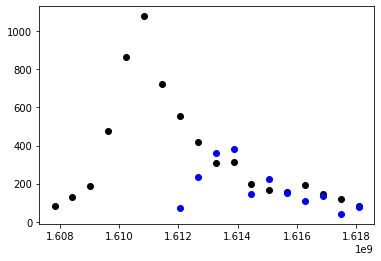

In [80]:
stride = 1 
lag = 3
dd = 1
q = 4
XX = ss[0:ss.size - q - lag * dd:stride]
print(XX)
for i in range(1,lag): 
  X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
  XX=np.column_stack((XX,X))
print(XX)
yy = ss[lag*dd+q::stride]
print(yy)
tt = t_full[lag*dd+q::stride]
print(tt)
from sklearn.model_selection import train_test_split 
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

from sklearn.linear_model import Ridge 
model = Ridge(fit_intercept=False).fit(XX[train], yy[train]) 
print(model.intercept_, model.coef_)

y_pred = model.predict(XX) 
print(y_pred)
plt.scatter(t_full, ss, color='black')
plt.scatter(tt, y_pred, color='blue')

ValueError: ignored

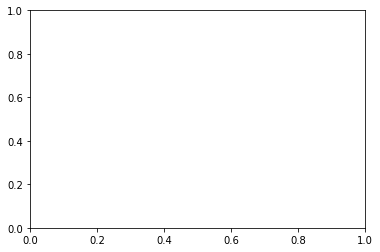

In [47]:
y_pred = model.predict(XX)
# print(XX) 
# plt.scatter(XX, yy, color='black')
plt.scatter(tt, y_pred, color='blue')
plt.xlabel('time (days)')
plt.ylabel('#bikes')
plt.legend(['training data','predictions'],loc='upper right')
day=math.floor(24*60*60/dt) # number of samples per day 
plt.xlim((4*7,4*7+4)) 
plt.show()